# 4 point measurements. 

Here I plan to create some code that is purely aimed at plotting the 4 point data and extracting the fluorescence intensity from the datasets for both the ODMR and reference data sets. 

In [341]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plot

In [342]:
def load_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = np.loadtxt(file_path)
    return(data_array)

In [343]:
def load_params(file_path):
    # load in the params data. 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

In [344]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

In [345]:
def plot_heat_map(freq, odmr_data, dwell_time):
    # plot the full ODMR data as a heatmap. 
    number_of_scans = len(odmr_data[0, 1, :])
    Y = np.linspace(1, number_of_scans, number_of_scans) 
    
    norm_odmr = []
    
    fig1, ax1 = plot.subplots()
 #   for i in range(len(odmr_data)):
 #       norm_odmr.append()
    print(freq)
    print(Y)
    print(odmr_data[0,1,0:10])
    
    
    
    hm = ax1.pcolormesh(freq, Y, odmr_data, cmap = 'viridis', shading='auto')
    fig1.colorbar(hm, label = '\ncounts per ' + str(dwell_time) + r' $\mu$s')
    ax1.set_xlim(np.min(freq),np.max(freq))
    ax1.set_xticks(np.arange(np.min(freq), np.max(freq), 0.05))
    ax1.set_xlabel('Microwave Frequency (GHz)')
    ax1.set_ylabel('Number of scans')
    
    return(fig1, ax1)

In [346]:
def reshape_data(reference_data, odmr_data, params_values):
    '''Here we re-shape the reference and the ODMR datasets into a 3D array, 
    based on the number of line scans, frequnecy points and repeats per frequnecy 
    have been used to build the ODMR dataset.'''
    
    # Create variables with the frequnecy scan parameters. 
    num_of_line_scans = int(params_values[4])
    num_of_freqs =  int(1000*(params_values[1]-params_values[0])/params_values[2]) + 1
    points_per_freq = int(params_values[8])
    print(num_of_line_scans, num_of_freqs, points_per_freq)
    # Reshape the ODMR and reference datasets. 

    odmr_shape_3D = odmr_data[0:num_of_freqs*points_per_freq].reshape(num_of_line_scans, num_of_freqs, points_per_freq)
    reference_data_3D = reference_data[0:num_of_freqs*points_per_freq].reshape(num_of_line_scans, num_of_freqs, points_per_freq)
    
    return(odmr_shape_3D, reference_data_3D)

In [347]:
def mean_data(odmr_data):
    # find the mean data 
    mean_odmr_data_points =  np.mean(odmr_data, axis = 2)
    mean_odmr_data_points_and_linescans =  np.mean(mean_odmr_data_points, axis = 0)
    return(mean_odmr_data_points, mean_odmr_data_points_and_linescans)

In [348]:
def normalise_data(reference_data, odmr_data):
    '''Here we normalise the ODMR dataset to the reference data.'''

    norm_odmr_data = odmr_data/reference_data
    return(norm_odmr_data)

In [349]:
def normalise_data_error_propogation(norm_odmr_4_point, four_points_ODMR_error, four_points_reference_error,
                                    four_point_reference_data, four_point_odmr_data):
    '''Calculating the error associated with each of the individual repeats of the 4 frequnecy points in the dataset.'''
    
    delta_I_odmr = four_points_ODMR_error/four_point_odmr_data
    delta_I_ref = four_points_reference_error/four_point_reference_data
    
    delta_I_normalised = norm_odmr_4_point * np.sqrt(delta_I_odmr**2 + delta_I_ref**2)
    
    return(delta_I_normalised)

In [350]:
def error_mean_values(norm_odmr_4_point, norm_ODMR_errors, mean_norm_4_point_odmr):
    'fghb'
    
    num_of_freq_points = norm_odmr_4_point.shape[1]
    num_of_measurements = norm_odmr_4_point.shape[2]
    
    square_error_store = np.zeros([num_of_freq_points, 1])
    
    for i in range(num_of_freq_points):
        for j in range(num_of_measurements):
            square_error_store[i,0] = square_error_store[i,0] + np.power((norm_ODMR_errors[0,i,j] / norm_odmr_4_point[0,i,j]), 2)
        
       
        square_error_store[i,0] = mean_norm_4_point_odmr[i] * (np.sqrt((square_error_store[i,0])) / num_of_measurements)
        print(np.round(mean_norm_4_point_odmr[i],4), np.round(square_error_store[i,0],4))
       # square_error_store[i,0] = mean_norm_4_point_odmr[i] * np.mean(norm_ODMR_errors[0,i,:]) / np.sqrt(num_of_measurements)
   
    #print(np.mean(norm_ODMR_errors, axis = 2) )
    #print(np.sqrt(num_of_measurements))
    #print(mean_norm_4_point_odmr)
    
    
    return(square_error_store)
    #return(mean_norm_4_point_odmr * np.mean(norm_ODMR_errors, axis = 2) / np.sqrt(num_of_measurements))

In [393]:
def norm_errors(mean_odmr_data, mean_ref_data, normalised_ODMR):
    '''Here we calculate the error for the 4 point ODMR dataset when normalised against the referenced dataset. 
    error calc: 
    delta I_norm  = I_norm * sqrt((delta I_odmr/I_odmr)^2 + (delta I_ref/I_ref)^2)'''

    delta_I_odmr = np.std(mean_odmr_data, axis = 2, ddof = 1)
    delta_I_ref = np.std(mean_ref_data, axis = 2, ddof = 1)
    
    frac_error_I_odmr = np.power((delta_I_odmr/np.mean(mean_odmr_data, axis = 2)), 2)
    frac_error_I_ref = np.power((delta_I_ref/np.mean(mean_ref_data, axis = 2)), 2)
    
    delta_I_norm = normalised_ODMR * np.sqrt(frac_error_I_odmr + frac_error_I_ref)

    
    return(delta_I_norm)

In [454]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
#######

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.

date = '20210920'
set_plot_params()

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\2021\\' + date + '\\'

four_point_data_set = '_4_point_referenced_odmr_05' # Short hand for the file name. 

# Set the file names for all 4 data sets recorded from the experiment. 
four_point_file_name_ODMR1 = date + four_point_data_set + '_ODMR1.dat'
four_point_file_name_ODMR2 = date + four_point_data_set + '_ODMR2.dat'
four_point_file_name_Ref1 = date + four_point_data_set  + '_Ref1.dat'
four_point_file_name_Ref2 = date + four_point_data_set  + '_Ref2.dat'

# Extract the ODMR and reference datasets from the data we are looking at. 
four_point_odmr_data = load_data(folder_path + four_point_file_name_ODMR1)
four_point_reference_data = load_data(folder_path + four_point_file_name_Ref1)

# Get the parameters for the experiment. 
four_point_params_file = load_params(folder_path + date  + four_point_data_set + '_Params.txt')
four_point_params_values = four_point_params_file['Parameter value']

# Need to have the four_freqs array layered as follows [F1, F2, F3, F4] due to riggering problems in the software.  
four_freqs = [2.858 ,2.860, 2.878, 2.88]

### Get the raw ODMR data. 

1 4 1000


Text(0.5, 0, 'Microwave Frequnecy (GHz)')

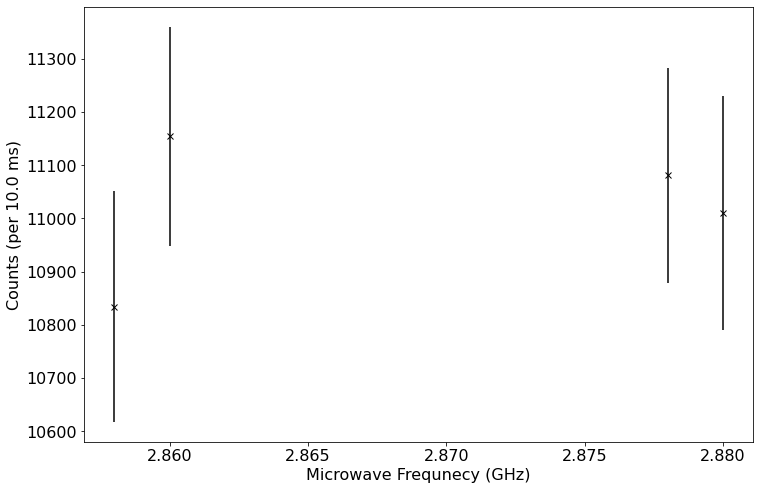

In [455]:
# Reshape the data so that it can be used for the following script. 
four_point_odmr_data, four_point_reference_data = reshape_data(four_point_reference_data, 
                                                               four_point_odmr_data, four_point_params_values)

# Generate the error arrays for the ODMR and reference data. 
four_points_ODMR_error = np.sqrt(four_point_odmr_data) # shot noise limit approximation
four_points_reference_error = np.sqrt(four_point_reference_data) # shot noise limit approximation

# Get the mean fluorescent value from the dataset and the standard deviation of the results. 
mean_full_fluorescence_intensity = np.mean(four_point_odmr_data, axis = 2)
std_full_fluorescence_intenisty = np.std(four_point_odmr_data, axis = 2, ddof = 1)
sqrt_mean_full_fluorescence_intensity = 2.2*np.sqrt(mean_full_fluorescence_intensity)

mean_full_fluorescence_intensity =  np.roll(mean_full_fluorescence_intensity, 1)
std_full_fluorescence_intenisty =  np.roll(std_full_fluorescence_intenisty, 1)
sqrt_mean_full_fluorescence_intensity = np.roll(sqrt_mean_full_fluorescence_intensity, 1)

fig, ax = plot.subplots()
ax.errorbar(four_freqs, mean_full_fluorescence_intensity[0], std_full_fluorescence_intenisty[0], marker = 'x', 
           linestyle = '', color = 'k')

ax.set_ylabel('Counts (per ' + str(four_point_params_values[3]/1000) + ' ms)')
ax.set_xlabel('Microwave Frequnecy (GHz)')

[[0.02714011 0.02396093 0.02422624 0.0269711 ]]


Text(0, 0.5, 'Normalised Counts (A.U.)')

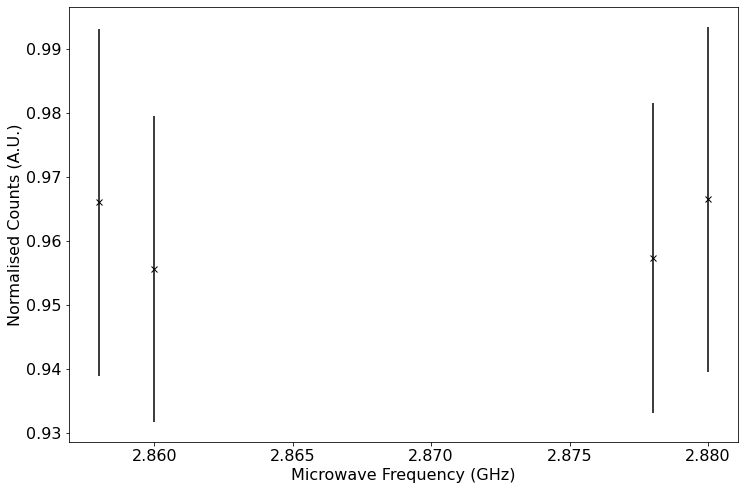

In [456]:
# Normalise the ODMR data against the reference data. 
norm_odmr_4_point = normalise_data(four_point_reference_data, four_point_odmr_data)
std_norm_odmr_4_point = np.array(np.std(norm_odmr_4_point, axis = 2, ddof = 1))

## Create the error for the normalised ODMR dataset. 
mean_ref_intenisty = np.mean(four_point_reference_data, axis = 2)

#norm_ODMR_errors = normalise_data_error_propogation(norm_odmr_4_point, four_points_ODMR_error, four_points_reference_error,
#                                    four_point_reference_data, four_point_odmr_data)

# Mean of the normalise dataset. 
# mean_odmr_freq_points = mean for all the points recorded per frequnecy, but not linescans. 
# mean_norm_odmr_full = Mean fluorescence value for all ODMR data points taken per freq. 
mean_odmr_4_point_freq_points, mean_norm_4_point_odmr = mean_data(norm_odmr_4_point)
#four_point_mean_norm_error = error_mean_values(norm_odmr_4_point, norm_ODMR_errors, mean_norm_4_point_odmr)

four_point_mean_norm_error = norm_errors(four_point_odmr_data, four_point_reference_data, mean_odmr_4_point_freq_points)

# roll the values +1 spaces in the array to correct for problems in the measurement regime. 
mean_norm_4_point_odmr = np.roll(mean_norm_4_point_odmr, 1)
#four_point_mean_norm_error = np.roll(std_norm_odmr_4_point, 1)
four_point_mean_norm_error = np.roll(four_point_mean_norm_error, 1)

print(four_point_mean_norm_error)
plot.errorbar(four_freqs, mean_norm_4_point_odmr, four_point_mean_norm_error[0], color = 'k', marker = 'x',
             linestyle = '')
plot.xlabel('Microwave Frequency (GHz)')
plot.ylabel('Normalised Counts (A.U.)')


In [457]:
output_data_folder = 'H:\\My Documents\\Strathclyde_Back_up\\Thesis and Planning\\Thesis_plots\\' + date + '\\'
output_data_file = output_data_folder + four_point_file_name_ODMR1[0:-13] + '_normalised_intensity_analysis.txt'
#print(mean_full_fluorescence_intensity[0][1])

In [458]:
# Checking to see if the folder exists in which to save the data, and creating it if it does not
if not os.path.exists(output_data_folder):
    os.makedirs(output_data_folder)
    # Checking the output file exists and creating and initialising it if not

if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('File name' +  '\t' + r'Dwell time ($\mu$s)' + '\t' +
                     'Number of Repeats' + '\t' +  
                     'I_1 (per dwell time)' + '\t' + 'STD(I_1) (per dwell time)' + 
                      '\t' + 'I_2 (per dwell time)' + '\t' +
                     'STD(I_2) (per dwell time)' + '\t'  
                     + 'I_3 (per dwell time)' + '\t' + 'STD(I_3) (per dwell time)' + '\t' + 
                     'I_4 (per dwell time)' + '\t' + 'STD(I_4) (per dwell time)' + '\t' + 
                     'I_1_norm ' + '\t' + 'error I_1_norm ' + 
                      '\t' + 'I_2_norm ' + '\t' + 'error I_2_norm ' + '\t'  
                     + 'I_3_norm ' + '\t' + 'error I_3_norm ' + '\t' + 
                     'I_4_norm ' + '\t' + 'error I_4_norm' + '\n')
            
with open(output_data_file, "a") as wf:
        wf.write(four_point_file_name_ODMR1  + ' \t' + str(four_point_params_values[3]) + ' \t' +
                 str(four_point_params_values[8]) + '\t' +
                 str(mean_full_fluorescence_intensity[0][0]) + " \t"  + str(std_full_fluorescence_intenisty[0][0]) + " \t" +  
                 str(mean_full_fluorescence_intensity[0][1]) + " \t"  + str(std_full_fluorescence_intenisty[0][1]) + " \t" +
                 str(mean_full_fluorescence_intensity[0][2]) + " \t"  + str(std_full_fluorescence_intenisty[0][2]) + " \t" + 
                 str(mean_full_fluorescence_intensity[0][3]) + " \t"  + str(std_full_fluorescence_intenisty[0][3]) + " \t" + 
                 
                 str(mean_norm_4_point_odmr[0]) + " \t"  + str(four_point_mean_norm_error[0][0]) + " \t" +  
                 str(mean_norm_4_point_odmr[1]) + " \t"  + str(four_point_mean_norm_error[0][1]) + " \t" +
                 str(mean_norm_4_point_odmr[2]) + " \t"  + str(four_point_mean_norm_error[0][2]) + " \t" + 
                 str(mean_norm_4_point_odmr[3]) + " \t"  + str(four_point_mean_norm_error[0][3]) + " \t" +
                 ' \n')

In [448]:
#fig1, ax1 = plot_heat_map(four_freqs, four_point_odmr_data, four_point_params_values[3])

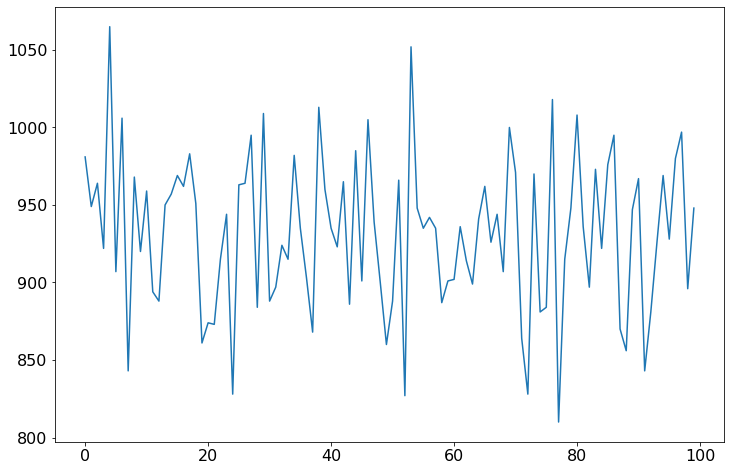

In [78]:
plot.plot(np.linspace(0,99, 100), four_point_odmr_data[0,3,:])


0.4714045207910317


In [398]:
print(four_point_params_file)

            Parameter name  Parameter value
0         Scan Begin (GHz)            2.800
1           Scan End (GHz)            2.803
2         Scan Steps (MHz)            1.000
3  Pixel Dwell Time (mu-s)        10000.000
4             Scan Repeats            1.000
5        Scan was Averaged            0.000
6   Microwave Dwell (mu-s)        10000.000
7       AOM Pulse Freq(Hz)            1.000
8            Point Repeats         1000.000
